In [259]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp
import mosek
from scipy.stats import lognorm
import time
from scipy.optimize import minimize

In [66]:
c = 4
p = 8
s = 2
l = 4

def profit(y,d):
    return(p*np.minimum(y,d) - c* y + s*np.maximum(y-d,0)- l*np.maximum(d-y,0))

def y_opt(alpha,p,c,s,l, mu,sigma):
    E = c-s
    U = p+l-c
    V = p-c
    F1 = lognorm.ppf(U*alpha/(E+U), sigma, scale=np.exp(mu))
    F2 = lognorm.ppf((E*(1-alpha)+U)/(E+U), sigma, scale=np.exp(mu))
    return((E+V)/(E+U)*F1+(U-V)/(E+U)*F2)
    


In [57]:
def f_explog(x,a,b):   #### default: a=0.1, b=2
    if x > 0 :
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        c3 = -np.exp(a+1)*c1
        term = (x+e)*np.exp(a*np.log(x+e)**b) 
        return(c1*term + c2*x + c3)
    else:
        return(np.exp(x)-1)
    
def df_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        term = np.exp(a*(np.log(x+e))**b)*(a*b*(np.log(x+e))**(b-1)+1)
        return(c1*term + c2)
    else:
        return(np.exp(x))
    
    
def ddf_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        
        term1 = a*b/(x+e)*np.exp(a*np.log(x+e)**b)
        term2 = (b-1)*np.log(x+e)**(b-2) + np.log(x+e)**(b-1) + a*b*np.log(x+e)**(2*b-2)
        return(c1*term1*term2)
    else:
        return(np.exp(x))
    
    
def CVaR(x,alpha):
    return np.maximum(1/alpha*x,0)

def dCVaR(x,alpha):
    if x > 0:
        return(1/alpha)
    else:
        return(0)

def KL(x):
    return np.exp(x)-1

    
    
def log_bar(x):
    if x>0:
        return(-np.log(x))
    else:
        return np.inf
    
def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] >= alpha:
        return(-x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(-1/alpha*(Ex+last))
    


In [61]:
X = np.arange(-2,6,1)
p_X = np.zeros(len(X))+ 1/len(X)
cvar_fast(0.3,X,p_X)

1.25

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [8]:

def f_lexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + lbda * f_explog((arg+the1)/lbda,a,b)
    return(s1/N-the1-the2+lbda*r)

def grad_flexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    grad = np.zeros(3)
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + df_explog((arg+the1)/lbda,a,b)
        s2 = s2 + df_explog((arg+the1)/lbda,a,b)* dCVaR(the2-X[i],alpha)
        s3 = s3 + f_explog((arg+the1)/lbda,a,b) - df_explog((arg+the1)/lbda,a,b) * ((arg+the1)/lbda)
    
    grad[0] = -1 + s1/N
    grad[1] = -1 + s2/N
    grad[2] = r + s3/N
    return(grad)

def f_constr(x):
    return -x[2]

def grad_f_constr(x):
    return np.array([0,0,-1])

In [9]:
def kl_cvar_ball(alpha,x,p,r):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    w = cp.Variable(n)
    s = cp.Variable(n)
    constraints = []
    som = 0
    for i in range(n):
        #if wbln_factor(-x[i],0,np.sqrt(1.5)) >= 1e-5:
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        constraints.append((w[i] - lbda) <= t[i])   #2/(-x[i])*
        constraints.append(cp.kl_div(lbda,w[i])+lbda+s[i]-w[i]<= 0)
        som = som + t[i]*p[i]
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value, lbda.value)

In [200]:
def ellipsoid_constr_method(f_obj, f_constr, grad_f, grad_f_constr, x0, max_iter, r_e, para):
    n = len(x0)
    x = x0
    P = np.identity(n)*r_e
    a,b,alpha,r,X = para
    f_best = f_obj(x0,X,alpha,a,b,r)
    x_opt = x0
    
    
    for i in range(max_iter):
        # Calculate the subgradient at the current point.
        if x[2] >= 0:
            g = grad_f(x,X,alpha,a,b,r)
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_obj(x,X,alpha,a,b,r)-f_best)/n_g
        else:
            g = grad_f_constr(x)
            #print('constr_g', (g.dot(P)).dot(g))
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_constr(x))/n_g
        
        # normalize subgradient.
        alfa = 0
    
        # Update the ellipsoid parameters.
        U = g_n.dot(P)
        c1 = (n**2/(n**2-1)) * (1-alfa**2)
        c2 = (1+n*alfa)/((n+1)*(1+alfa))*2
        x = x - (1+n*alfa)/(n+1)* P.dot(g_n)
        P = c1 * (P - c2 * np.outer(U,U))
        #print('x', x)
            
        if f_obj(x,X,alpha,a,b,r) < f_best and x[2] >= 0:
            f_best = f_obj(x,X,alpha,a,b,r)
            x_opt = x
            x_grad = grad_f(x,X,alpha,a,b,r)
        print('obj', f_best, 'sol', x_opt, np.max(P))
        
        if np.max(P) <= 1e-4:
            print('obj', f_best, 'sol', x_opt,'grad', x_grad,'P-norm', np.max(P))
            return(x_opt, f_best, x_grad)
    print('max iterations reached')

    return x_opt, f_best

In [223]:
def ellipsoid_explog(x0, max_iter,r_e,para):
    n = len(x0)
    x = x0
    P = np.identity(n)*r_e
    a,b,alpha,r,X = para
    f_best = np.inf
    x_opt = x0
    N = len(X)
    for steps in range(max_iter):
        if x[2] >= 0:
            the1 = x[0]
            the2 = x[1]
            lbda = x[2]
            f_obj = 0
            g = np.zeros(3)
            s1 = 0
            s2 = 0
            s3 = 0
            for i in range(N):
                arg = CVaR(the2-X[i],alpha)
                f_obj = f_obj + lbda * f_explog((arg+the1)/lbda,a,b)
                s1 = s1 + df_explog((arg+the1)/lbda,a,b)
                s2 = s2 + df_explog((arg+the1)/lbda,a,b)* dCVaR(the2-X[i],alpha)
                s3 = s3 + f_explog((arg+the1)/lbda,a,b) - df_explog((arg+the1)/lbda,a,b) * ((arg+the1)/lbda)
            
            f_obj = f_obj/N -the1-the2+lbda*r
            g[0] = -1 + s1/N
            g[1] = -1 + s2/N
            g[2] = r + s3/N
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            if f_obj < f_best and x[2] >= 0:
                f_best = f_obj
                x_opt = x
                x_grad = g
            #print('obj', f_best, 'sol', x_opt, np.max(P))
        else:
            g = np.array([0,0,-1])
            #print('constr_g', (g.dot(P)).dot(g))
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            
        alfa = 0
        U = g_n.dot(P)
        c1 = (n**2/(n**2-1)) * (1-alfa**2)
        c2 = (1+n*alfa)/((n+1)*(1+alfa))*2
        x = x - (1+n*alfa)/(n+1)* P.dot(g_n)
        P = c1 * (P - c2 * np.outer(U,U))
        
        
        if np.max(P) <= 1e-5:
            print('obj', f_best, 'sol', x_opt,'grad', x_grad,'P-norm', np.max(P))
            return(x_opt, f_best, x_grad)
    
    print('max iterations reached')

    return x_opt, f_best
                
    
            
    

In [276]:
np.random.seed(3)
mu = np.log(1)
sigma = 1
alpha = 0.05
demand = np.random.lognormal(mu,sigma,size= 10000)
frac = alpha* (p-c)/(p-s)
y_nom = y_opt(alpha,p,c,s,l, mu,sigma)


In [227]:
y_nom

4.200382320343616

In [230]:
demand

array([0.65918052, 0.94528687, 0.11810324, ..., 0.9901253 , 0.80423598,
       7.4239865 ])

In [367]:
a = 1/(2*(sigma*2)**2)
b = 2
alpha = 0.05
r = 1.2
x0 = np.array([-5,-12,1])


In [274]:
def one_dim_search(x_a, x_b,a,b,alpha,r,demand,x0, max_iter):
    y = np.arange(x_a,x_b,(x_b-x_a)/5)
    y = -np.sort(-y)
    f_min = np.inf
    y_min = x_a
    
    for steps in range(max_iter):
        for i in range(len(y)):
            obj = np.zeros(len(y))
            profit_vec = profit(y[i],demand)
            para = [a,b,alpha,r,profit_vec]
            obj[i] = ellipsoid_explog(x0, 400, 100000,para)[1]
            if obj[i] < f_min:
                f_min = obj[i]
                y_min = y[i]
            else:
                if i == 0:
                    return('choose better ub')
                else:
                    x
            
    
    
    

'ha'

In [257]:
objective_scipy(12,*args)

obj 44.386114010344855 sol [ -0.37222286 -31.05456332  23.24492537] grad [-1.86671490e-06  6.49148110e-04 -4.06668819e-06] P-norm 6.671266150413884e-06


44.386114010344855

In [369]:
y = np.arange(23.9,25,(25-23.9)/8)
risk = np.zeros(len(y))
prob = np.zeros(len(demand)) + 1/len(demand)
#demand = np.random.lognormal(mu,sigma,size= 5000)
for i in range(len(y)):
    print(y[i])
    profit_vec = profit(y[i], demand)
    para = [a,b,alpha,r,profit_vec]
    risk[i] = ellipsoid_explog(x0, 400, 100000,para)[1]
    

        

23.9
obj 47.70832958456104 sol [-5.84122447e-03 -4.74408975e+01  1.18310990e-01] grad [-0.00092021  0.00025789  0.0010576 ] P-norm 7.105281688049797e-06
24.037499999999998
obj 47.857584116127484 sol [-2.12393068e-03 -4.77584734e+01  4.30854068e-02] grad [ 0.00010562  0.00029468 -0.00254696] P-norm 6.907204791154248e-06
24.174999999999997
obj 48.13258412940007 sol [-2.13511836e-03 -4.80334626e+01  4.30823536e-02] grad [-0.00013075  0.00056756 -0.00301433] P-norm 7.761890579867928e-06
24.312499999999996
obj 48.40758404817543 sol [-2.14903442e-03 -4.83084385e+01  4.31360772e-02] grad [-0.00042529 -0.0003679  -0.00024457] P-norm 8.063885119101582e-06
24.449999999999996
obj 48.68258434153521 sol [-2.11522629e-03 -4.85836228e+01  4.30179942e-02] grad [ 0.00016922 -0.00081047 -0.00296393] P-norm 9.846273011652251e-06
24.587499999999995
obj 48.9575840761387 sol [-2.08434687e-03 -4.88583224e+01  4.31866432e-02] grad [ 1.10219436e-03  6.03701480e-04 -5.89598360e-05] P-norm 7.134451430676594e-06


In [ ]:
30.6675

In [363]:
##### optimal y_rob determined by hand
radius = np.array([0.01,0.03,0.05,0.07,0.1,0.2,0.3,0.4,0.42,0.46,0.47,0.5,0.7,1])
y_rob = np.array([5.38,6.724,7.69,8.36,9.9,14.4,15.5,16.3,16.38,22.71,23.06,23.5,23.8,23.9])

In [366]:
len(radius)

14

In [364]:
np.savetxt('y_rob.txt', y_rob)
np.savetxt('radius.txt', radius)

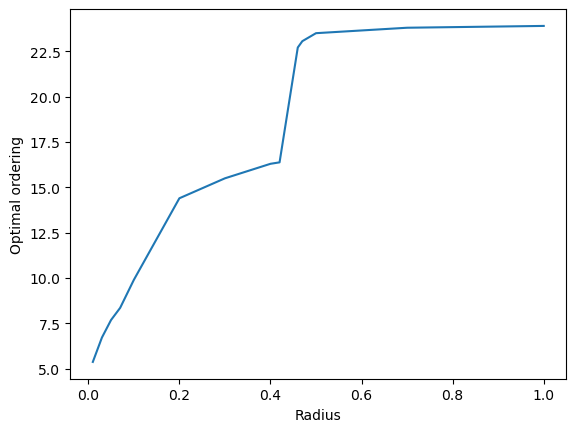

In [365]:
plt.plot(radius, y_rob)
plt.xlabel('Radius')
plt.ylabel('Optimal ordering')
plt.savefig('Newsvendor_radius.eps', format = 'eps')

In [249]:
np.savetxt('newsvendor_risk.txt', risk)
np.savetxt('newsvendor_y.txt', y)

In [283]:
y2 = np.loadtxt('newsvendor_y.txt')
risk2 = np.loadtxt('newsvendor_risk.txt')

In [284]:
ind = np.argmin(risk2)
y2[ind]

23.0

In [293]:
y2

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

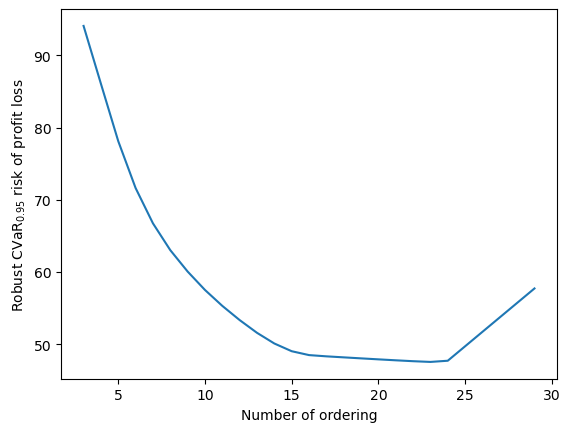

In [248]:
plt.plot(y,risk)
plt.xlabel('Number of ordering')
plt.ylabel('Robust $\mathrm{CVaR}_{0.95}$ risk of profit loss')
plt.savefig('Newvendor_Composite.eps', format = 'eps')

In [216]:
ind = np.argmin(risk)
y[ind]

15

In [18]:
np.percentile(demand,50)

10.136449106584525

In [243]:
np.random.seed(3)
demand = np.random.lognormal(mu,sigma,size= 10000)
profit_vec = profit(4, demand)
para = [a,b,alpha,r,profit_vec]

In [232]:
t_b = time.time()
ellipsoid_constr_method(f_lexp, f_constr, grad_flexp, grad_f_constr, x0, 400, 100000, para)
t_e = time.time()
print(t_e-t_b)

obj 117.44296260597139 sol [ -5 -50  30] 112360.34652848319
obj 117.44296260597139 sol [ -5 -50  30] 126295.56219746218
obj 103.61886341223934 sol [ -5.42220067 -41.63605893  81.31991963] 141788.13754304152
obj 103.61886341223934 sol [ -5.42220067 -41.63605893  81.31991963] 158098.0728421492
obj 103.61886341223934 sol [ -5.42220067 -41.63605893  81.31991963] 177675.9596334967
obj 103.61886341223934 sol [ -5.42220067 -41.63605893  81.31991963] 184009.8185662676
obj 103.61886341223934 sol [ -5.42220067 -41.63605893  81.31991963] 138930.7756647572
obj 103.30703956658786 sol [-36.20367554  -6.60682144  78.68901691] 78766.1510822671
obj 100.32089841980735 sol [  1.47282406 -38.17509759  73.41944813] 75836.25236871284
obj 100.32089841980735 sol [  1.47282406 -38.17509759  73.41944813] 80207.8145929118
obj 100.32089841980735 sol [  1.47282406 -38.17509759  73.41944813] 74873.2669260657
obj 98.54629433105359 sol [  3.61441499 -31.57274599  78.35822123] 82112.4903422171
obj 98.54629433105359 so

obj 95.32691988561533 sol [ -3.58129395 -17.38286876  77.2934187 ] 2.866234927064282
obj 95.32691988561533 sol [ -3.58129395 -17.38286876  77.2934187 ] 2.351379162092358
obj 95.32685438203563 sol [ -3.56238792 -17.35059836  77.20308419] 2.2974559065871496
obj 95.32685438203563 sol [ -3.56238792 -17.35059836  77.20308419] 1.8710978028445855
obj 95.32685438203563 sol [ -3.56238792 -17.35059836  77.20308419] 1.5975677441463914
obj 95.32685438203563 sol [ -3.56238792 -17.35059836  77.20308419] 1.1131462016603222
obj 95.32685305704787 sol [ -3.57999592 -17.38595598  77.15877928] 0.9775374294696154
obj 95.32685305704787 sol [ -3.57999592 -17.38595598  77.15877928] 0.9943449810969961
obj 95.32682659522335 sol [ -3.49798102 -17.36871539  77.17261028] 1.1173338751011115
obj 95.32682659522335 sol [ -3.49798102 -17.36871539  77.17261028] 1.1568704028916657
obj 95.32682659522335 sol [ -3.49798102 -17.36871539  77.17261028] 1.0675628245621585
obj 95.32682659522335 sol [ -3.49798102 -17.36871539  77

In [244]:
t_b = time.time()
print(ellipsoid_explog(x0, 400, 100000,para))
t_e = time.time()
print(t_e-t_b)

obj 86.05671749691216 sol [ -3.15509709 -15.75005369  69.53374884] grad [7.99608534e-07 1.28597227e-06 3.87425337e-07] P-norm 9.287722510754881e-06
(array([ -3.15509709, -15.75005369,  69.53374884]), 86.05671749691216, array([7.99608534e-07, 1.28597227e-06, 3.87425337e-07]))
29.071765422821045


In [ ]:
61